# TP3 Deep Learning CNN : 
> Ce TP est effectué par :
**Sandra Mourali** **Anas Chaibi** **Salma Ghabri** **Aziz Bellaaj**
---

In [1]:
import numpy as np
import keras.backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
K.set_image_data_format('channels_first') 
seed = 7 
np.random.seed(seed)


In [2]:
def plotHistory(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy Curve')

    plt.subplot(1, 3, 2)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.plot(history.history['mean_io_u'])
    plt.plot(history.history['val_mean_io_u'])
    plt.ylabel('IoU')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'])
    plt.title('IoU Curve')

    plt.subplot(1, 3, 3)
    plt.grid()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.title('Loss Curve')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.ylabel('Precision')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'])
    plt.title('Precision Curve')

    plt.subplot(1, 3, 2)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.ylabel('Recall')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'])
    plt.title('Recall Curve')

    plt.tight_layout()
    plt.savefig("combined_curves.pdf")
    plt.show()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    title = 'Normalized confusion matrix'
        
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
def predictModel(modelPath):
    loaded_model = load_keras_model(modelPath)
    (X_unseen, y_unseen), _, _ = get_data_mnist()
    X_unseen = X_unseen.reshape(X_unseen.shape[0], 28, 28, 1).astype('float32') / 255
    predictions = loaded_model.predict(X_unseen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_unseen, axis=1)
    classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # for MNIST
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=classes,
                        title='Confusion matrix')
    plt.show()

In [4]:
def get_data_mnist():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') 
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') 
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    num_classes = y_test.shape[1]
    return (X_train, y_train), (X_test, y_test), num_classes

In [5]:
IoU=tf.keras.metrics.MeanIoU(num_classes=16)
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=1)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Model score : %.2f%%" % (scores[1] * 100))
    print("Model error rate : %.2f%%" % (100 - scores[1] * 100))
    return history

def print_model_error_rate(model, X_test, y_test):
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Model score : %.2f%%" % (scores[1]*100))
    print("Model error rate : %.2f%%" % (100-scores[1]*100))

In [6]:
def save_keras_model(model, filename):
    model_json = model.to_json()
    with open(filename + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(filename + ".h5")
    
def load_keras_model(filename):
    json_file = open(filename + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename + ".h5")
    return loaded_model

In [7]:
(X_train, y_train), (X_test, y_test), num_classes = get_data_mnist()
num_classes

10

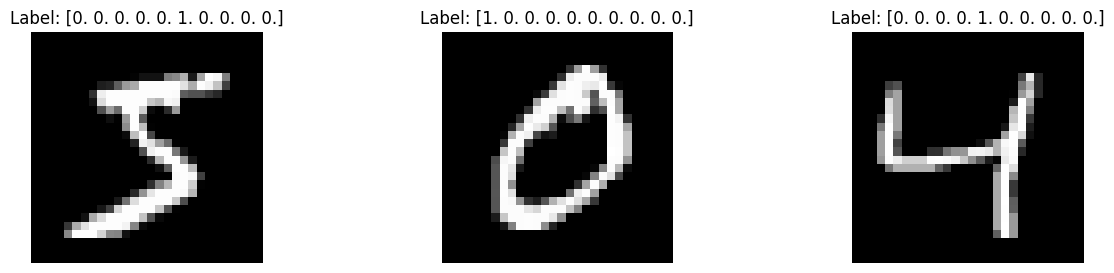

In [25]:
def plot_mnist_samples(X_train, y_train, num_samples=3):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y_train[i]}")
        plt.axis('off')
    plt.show()

(X_train, y_train), _, _ = get_data_mnist()
plot_mnist_samples(X_train, y_train)


# Model Definition :

In [8]:
def small_model(num_classes):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy',IoU,'precision','recall'])
    return model


num_classes = 10
(X_train, y_train), (X_test, y_test), num_classes = get_data_mnist()
small_cnn = small_model(10)
history_small=train_and_evaluate(small_cnn, X_train, y_train, X_test, y_test)

Epoch 1/10


c:\Users\HP OMEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6731 - loss: 2.1041 - mean_io_u: 0.4510 - precision: 0.7146 - recall: 0.6353 - val_accuracy: 0.9348 - val_loss: 0.2118 - val_mean_io_u: 0.4556 - val_precision: 0.9456 - val_recall: 0.9284
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9389 - loss: 0.2002 - mean_io_u: 0.4555 - precision: 0.9478 - recall: 0.9314 - val_accuracy: 0.9508 - val_loss: 0.1628 - val_mean_io_u: 0.4593 - val_precision: 0.9577 - val_recall: 0.9464
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9567 - loss: 0.1375 - mean_io_u: 0.4600 - precision: 0.9625 - recall: 0.9528 - val_accuracy: 0.9572 - val_loss: 0.1368 - val_mean_io_u: 0.4611 - val_precision: 0.9611 - val_recall: 0.9543
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9693 - loss: 0.1001 - mean_io_u: 0.4650 - precision: 0.9735 - recall: 0.9659 - val_accuracy: 0.9667 - val_loss: 0.1042 - val_mean_io_u: 0.4634 - val_precision: 0.9701 - val_recall

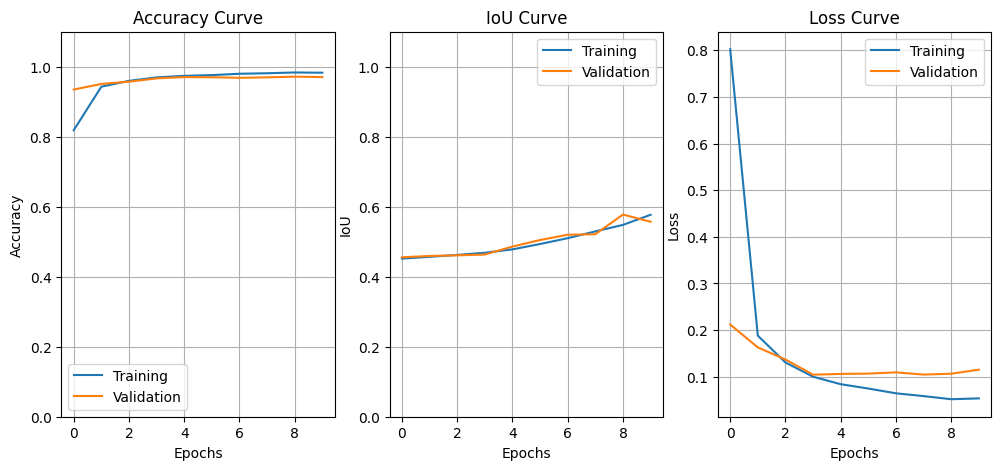

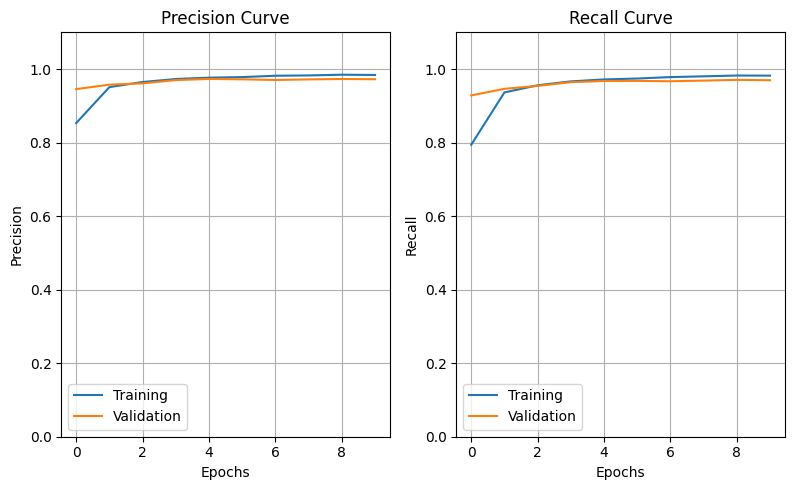

<Figure size 640x480 with 0 Axes>

In [9]:
plotHistory(history_small)

In [10]:
print_model_error_rate(small_cnn, X_test, y_test)

Model score : 97.04%
Model error rate : 2.96%


In [11]:
save_keras_model(small_cnn, "small_cnn.weights")

In [12]:
load_keras_model( "small_cnn.weights")

<Sequential name=sequential, built=True>

## Medium CNN :

In [13]:
def medium_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy',IoU,'precision','recall'])
    return model

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
medium_cnn = medium_cnn()
medium_history=train_and_evaluate(medium_cnn, X_train, y_train, X_test, y_test)

Epoch 1/10


c:\Users\HP OMEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7292 - loss: 0.9184 - mean_io_u: 0.4845 - precision: 0.8798 - recall: 0.5534 - val_accuracy: 0.9303 - val_loss: 0.2348 - val_mean_io_u: 0.4500 - val_precision: 0.9467 - val_recall: 0.9155
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9244 - loss: 0.2490 - mean_io_u: 0.4500 - precision: 0.9428 - recall: 0.9074 - val_accuracy: 0.9523 - val_loss: 0.1609 - val_mean_io_u: 0.4500 - val_precision: 0.9619 - val_recall: 0.9436
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9447 - loss: 0.1838 - mean_io_u: 0.4500 - precision: 0.9566 - recall: 0.9333 - val_accuracy: 0.9636 - val_loss: 0.1240 - val_mean_io_u: 0.4500 - val_precision: 0.9698 - val_recall: 0.9581
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9575 - loss: 0.1411 - mean_io_u: 0.4500 - precision: 0.9656 - recall: 0.9500 - val_accuracy: 0.9696 - val_loss: 0.0992 - val_mean_io_u: 0.4500 - val_precision: 0.9746 - val_recall: 0.

Model score : 98.07%
Model error rate : 1.93%


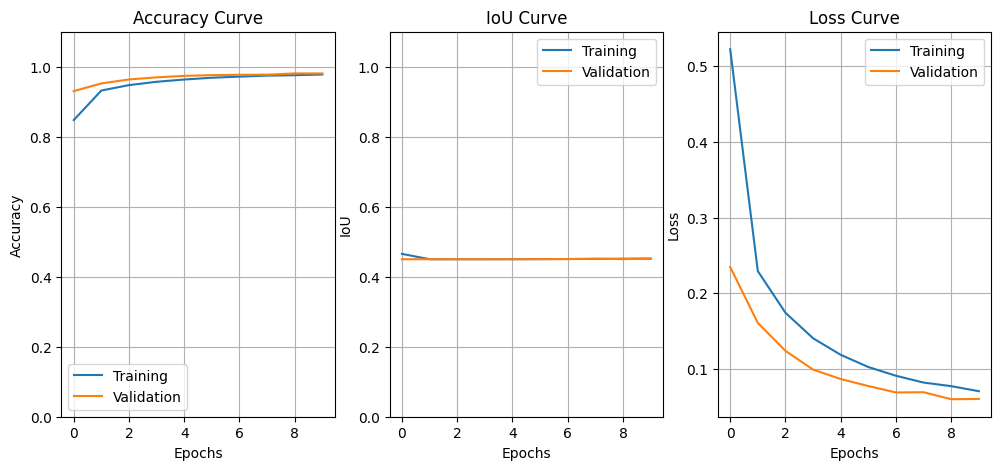

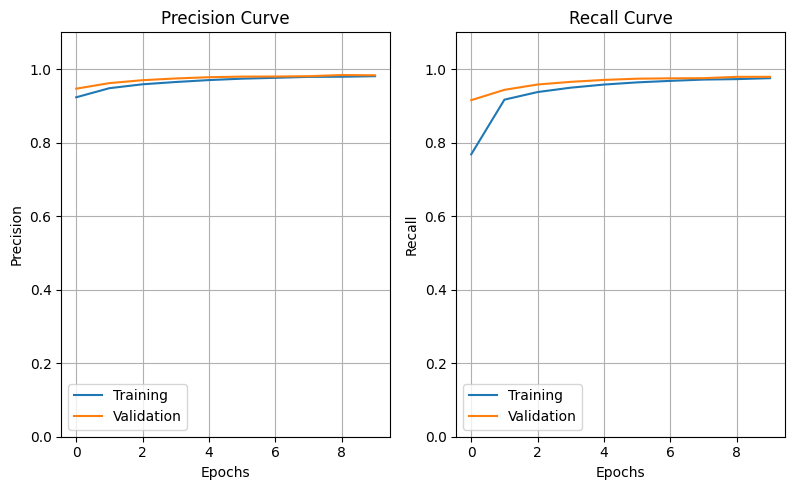

<Figure size 640x480 with 0 Axes>

In [14]:
print_model_error_rate(medium_cnn, X_test, y_test)
plotHistory(medium_history)
save_keras_model(medium_cnn, "medium_cnn.weights")

In [15]:
def large_cnn():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy',IoU,'precision','recall'])
    return model

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
large_cnn = large_cnn()
large_history=train_and_evaluate(medium_cnn, X_train, y_train, X_test, y_test)


Epoch 1/10
 10/300 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1015 - loss: 2.3458 - mean_io_u: 0.4500 - precision: 0.0000e+00 - recall: 0.0000e+00 

c:\Users\HP OMEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2107 - loss: 2.2543 - mean_io_u: 0.4500 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6187 - val_loss: 2.0221 - val_mean_io_u: 0.4500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6043 - loss: 1.8169 - mean_io_u: 0.4500 - precision: 0.6541 - recall: 0.0187 - val_accuracy: 0.8131 - val_loss: 1.0115 - val_mean_io_u: 0.4500 - val_precision: 0.9719 - val_recall: 0.3282
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7713 - loss: 0.9411 - mean_io_u: 0.4500 - precision: 0.9407 - recall: 0.4276 - val_accuracy: 0.8572 - val_loss: 0.5989 - val_mean_io_u: 0.4500 - val_precision: 0.9462 - val_recall: 0.7074
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8259 - loss: 0.6281 - mean_io_u: 0.4500 - precision: 0.9229 - recall: 0.6950 - val_accuracy: 0.8856 - val_loss: 0.4497 - val_mean_io_u: 0.4500 - val_precision: 0.9438 

Model score : 9.29%
Model error rate : 90.71%


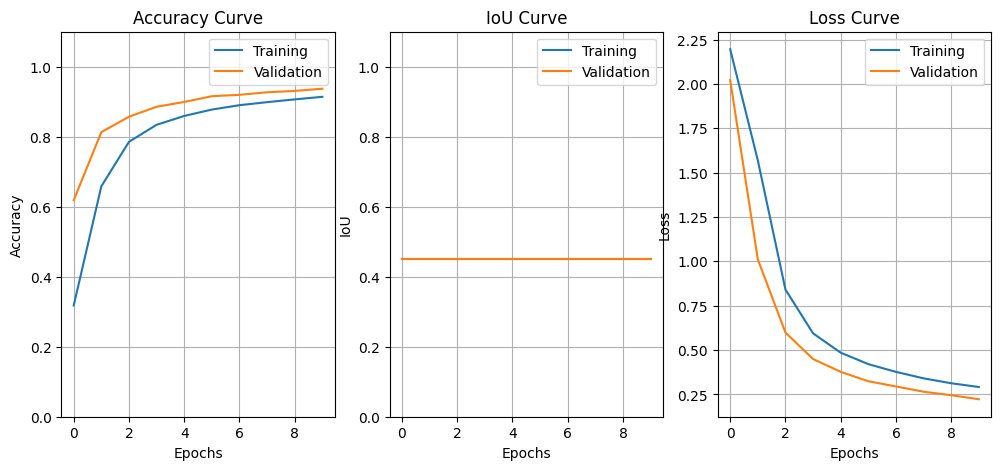

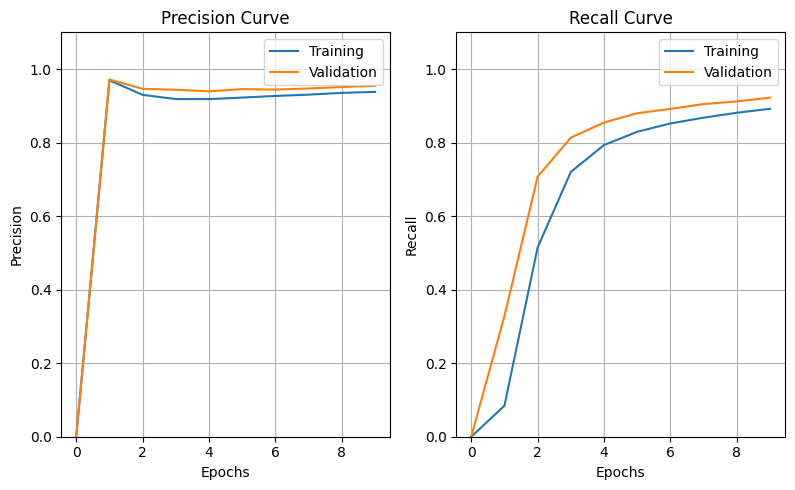

<Figure size 640x480 with 0 Axes>

In [16]:
print_model_error_rate(large_cnn, X_test, y_test)
plotHistory(large_history)
save_keras_model(large_cnn, "large_cnn.weights")

## Load model weights and perform classifications with it :

In [17]:
def load_keras_model(filename):
    json_file = open(filename + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename + ".h5")
    return loaded_model

loaded_model = load_keras_model("small_cnn.weights")

(X_unseen, y_unseen), _, _ = get_data_mnist()
X_unseen = X_unseen.reshape(X_unseen.shape[0], 28, 28, 1).astype('float32') / 255

predictions = loaded_model.predict(X_unseen)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [18]:
predictions

array([[0.08110575, 0.09459941, 0.1069556 , ..., 0.09091002, 0.10646176,
        0.09515148],
       [0.09867609, 0.08855215, 0.112051  , ..., 0.09006914, 0.10558708,
        0.09512312],
       [0.08476125, 0.09808241, 0.10815327, ..., 0.09334475, 0.10352606,
        0.09825513],
       ...,
       [0.08300009, 0.09111384, 0.10150869, ..., 0.08614623, 0.11086627,
        0.09718276],
       [0.09081311, 0.09213486, 0.10955142, ..., 0.08924562, 0.10574099,
        0.09165207],
       [0.0919093 , 0.08750904, 0.10608603, ..., 0.09275668, 0.11615544,
        0.09372807]], dtype=float32)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


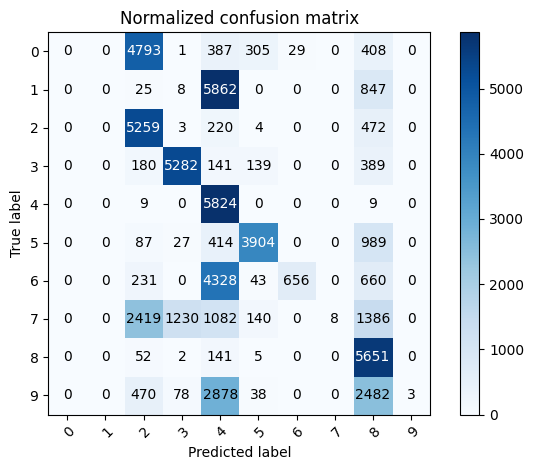

In [19]:
predictModel("small_cnn.weights")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


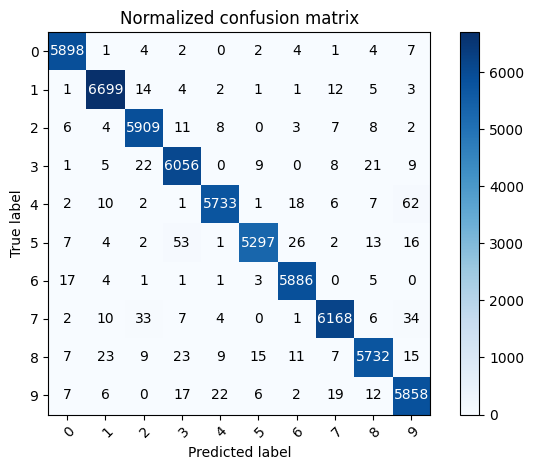

In [20]:
predictModel("medium_cnn.weights")

c:\Users\HP OMEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


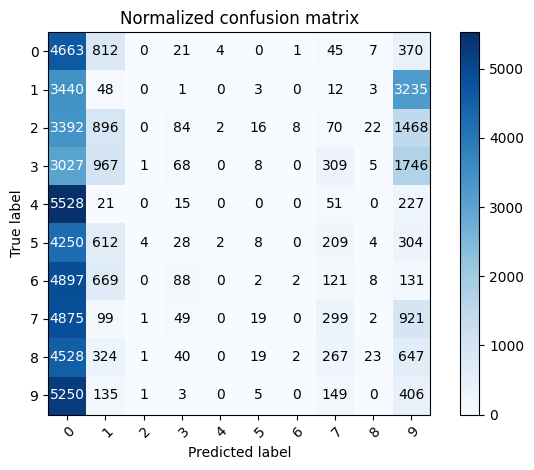

In [21]:
predictModel("large_cnn.weights")